# 照相机静止不动时的calibration parameters

## 介绍

3个file：from0，from10，from23三个csv文件，记录的是从三个marker获得的camera_to_base的transformation，

格式为(x,y,z,alpha,beta,gamma)

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [17]:
import os
os.sys.path


['/Users/sibohao/Desktop/data_process/01static_camera_calibration',
 '/Users/sibohao/miniforge3/lib/python39.zip',
 '/Users/sibohao/miniforge3/lib/python3.9',
 '/Users/sibohao/miniforge3/lib/python3.9/lib-dynload',
 '',
 '/Users/sibohao/.local/lib/python3.9/site-packages',
 '/Users/sibohao/miniforge3/lib/python3.9/site-packages',
 '/Users/sibohao/miniforge3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/sibohao/.ipython']

In [27]:
import sys
sys.path.append('/usr/local/opt/')
os.sys.path

['/Users/sibohao/Desktop/data_process/01static_camera_calibration',
 '/Users/sibohao/miniforge3/lib/python39.zip',
 '/Users/sibohao/miniforge3/lib/python3.9',
 '/Users/sibohao/miniforge3/lib/python3.9/lib-dynload',
 '',
 '/Users/sibohao/.local/lib/python3.9/site-packages',
 '/Users/sibohao/miniforge3/lib/python3.9/site-packages',
 '/Users/sibohao/miniforge3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/sibohao/.ipython',
 '/usr',
 '/usr',
 '/usr/local/opt/',
 '/usr/local/opt/',
 '/usr/local/opt/',
 '/usr/local/opt/']

In [28]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [29]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import scipy as sp
import IPython
import pandas as pd
import csv

import numpy.random as rd


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12,8

## ground truth of calibration parameter 

In [9]:
xt = -0.100
yt = 0.87529999
zt = 0.62499994
at = 1.57079633
bt = 0.00
ct = 0.00

## 读入三个csv文件

In [10]:
data_from0 = pd.read_csv("from0.txt",delimiter = " ")
data_from10 = pd.read_csv("from10.txt",delimiter = " ")
data_from23 = pd.read_csv("from23.txt",delimiter = " ")

In [11]:
drop_10=data_from10.index[data_from10['x'] == 0].tolist()
c= drop_10
df10=data_from10.drop(data_from10.index[c])
df10.describe()


,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.100670,0.881818,0.624827,1.151657,-0.000277,0.000034
std,0.016079,0.005350,0.015651,0.697537,0.002196,0.007242
min,-0.163900,0.868203,0.544234,0.000000,-0.014911,-0.032318
25%,-0.107449,0.877914,0.616122,0.000000,-0.001012,-0.003078
50%,-0.100561,0.881229,0.624647,1.568732,0.000000,0.000000
75%,-0.093475,0.885392,0.632851,1.574824,0.000396,0.002457
max,-0.038417,0.901527,0.685559,1.644100,0.022092,0.046263


## 通过marker10获得，位于link8上

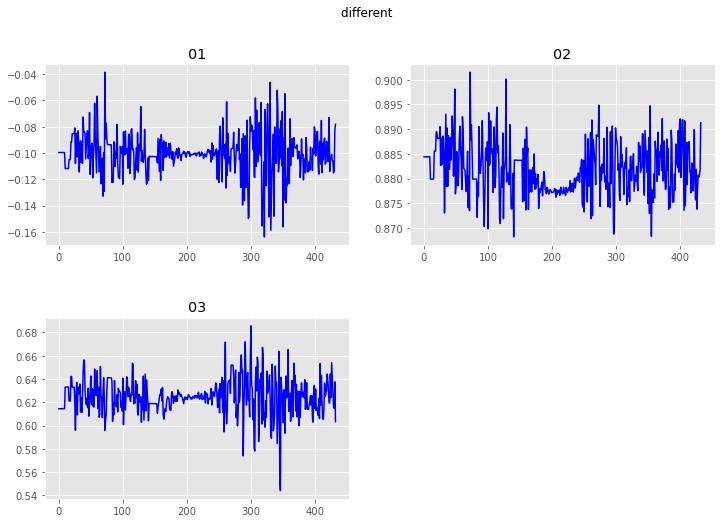

In [12]:
x = data_from10['x']
y = data_from10['y']
z = data_from10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')


### 去零

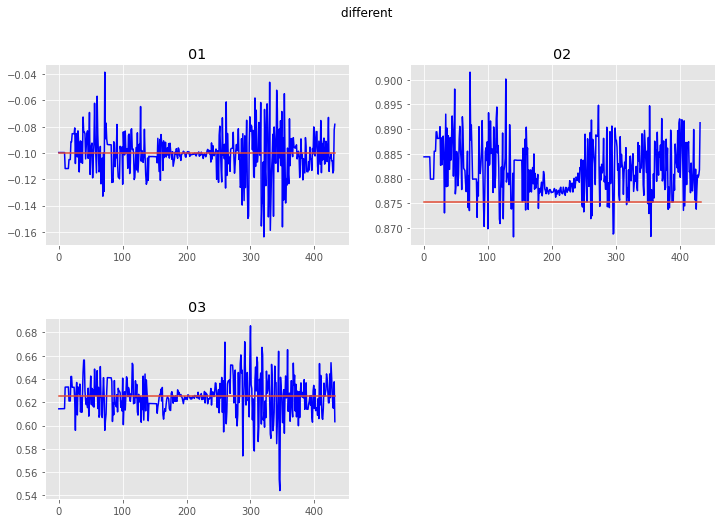

In [13]:
x10 = df10['x']
y10 = df10['y']
z10 = df10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z10, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 卡尔曼滤波器

当没有传感器输入时怎么办？

If at a time t the measurement is missing, only the time-update is computed and the measurement update must be skipped. 


https://math.stackexchange.com/questions/982982/kalman-filter-with-missing-measurement-inputs

In [14]:
# 6: x, y, z, dx, dy, dz; 3: observe conditions
kalman_pos = cv2.KalmanFilter(6, 3) 
#print(type())
# measurement matrix
kalman_pos.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)

# transition matrix
kalman_pos.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)


# Process Noise noise covariance
kalman_pos.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5

# Measurement Noise Covariance
kalman_pos.measurementNoiseCov = np.array([[1, 0, 0], 
                                        [0, 1, 0], 
                                        [0, 0, 1]], np.float32)*0.4


NameError: name 'cv2' is not defined

In [15]:
# initalize measurement and predictions
last_measurement_pos10 = current_measurement_pos10 = (data_from10['x'][0],data_from10['y'][0],data_from10['z'][0])
last_prediction_pos10 = current_prediction_pos10 = ([data_from10['x'][0]],[data_from10['y'][0]],[data_from10['z'][0]],
                                                    [0],[0],[0])
initial_state = 1
count = 0

In [32]:
def kalman_filter(position,orientation):  
    
    global current_measurement_pos10, last_measurement_pos10, current_prediction_pos10, last_prediction_pos10
    global initial_state,count

    count = count+1
    # save current prediction as last prediction
    last_prediction_pos10 = current_prediction_pos10
    # save current measurement as last measurement
    last_measurement_pos10 = current_measurement_pos10

    x = position[0]
    y = position[1]
    z = position[2]
    
    # current_measurement
    current_measurement_pos10 = np.array([[np.float32(x)], [np.float32(y)], [np.float32(z)]])     
    
    if(initial_state==0):
        # prediction phase
        current_prediction_pos10 = kalman_pos.predict() 
    
        # correction phase
        result_pos_10 = kalman_pos.correct(current_measurement_pos10) 

    else:
        initial_state=0
        result_pos_10 = current_prediction_pos10        
        kalman_pos.statePost = np.asarray(current_prediction_pos10, dtype = np.float32)
        kalman_pos.errorCovPost = np.eye(6,dtype = np.float32)

    return result_pos_10, orientation

In [935]:
filtered_pos_array10 = np.zeros((len(data_from10['x']),3))

In [936]:
for i in range (0,len(data_from10['x'])):
    pos=(data_from10['x'][i],data_from10['y'][i],data_from10['z'][i])
    ori=(data_from10['alpha'][i],data_from10['beta'][i],data_from10['gamma'][i])
    filtered_pos, filtered_ori = kalman_filter(pos,ori)

    filtered_pos_array10[i][0] = filtered_pos[0][0]
    filtered_pos_array10[i][1] = filtered_pos[1][0]
    filtered_pos_array10[i][2] = filtered_pos[2][0]
    

In [937]:
print(filtered_pos_array10)

[[-0.09964142  0.88439757  0.61436307]
 [-0.09964278  0.88439709  0.61437702]
 [-0.09964442  0.88439673  0.61439431]
 ...
 [-0.1021695   0.88046134  0.62900156]
 [-0.10040662  0.8804875   0.63002574]
 [-0.09832214  0.88142329  0.62772971]]


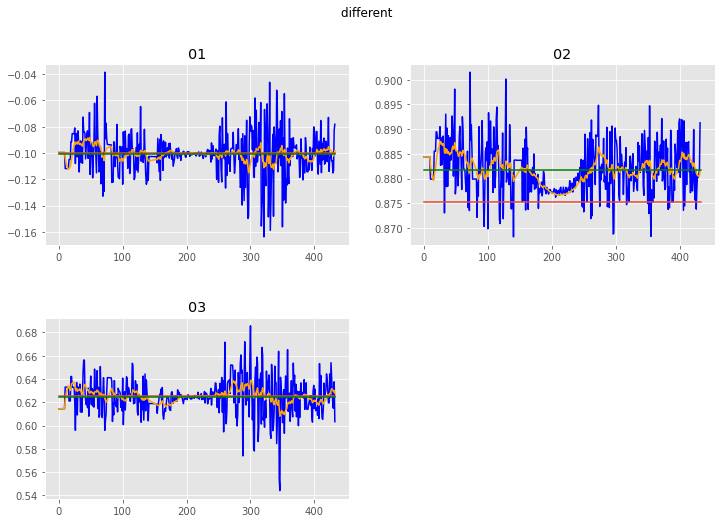

In [938]:
x10 = df10['x']
y10 = df10['y']
z10 = df10['z']
xf10 = filtered_pos_array10[:,0]
yf10 = filtered_pos_array10[:,1]
zf10 = filtered_pos_array10[:,2]

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x10, color='blue')
ax221.plot(xf10, color='orange')
mx = df10[['x']].mean(axis=0)
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
x_average = [mx,mx]
ax221.plot(x_coordinates, y_coordinates)
ax221.plot(x_coordinates, x_average,color='green')

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y10, color='blue')
ax222.plot(yf10, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

my = df10[['y']].mean(axis=0)
y_average = [my,my]
ax222.plot(x_coordinates, y_average,color='green')

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z10, color='blue')
ax223.plot(zf10, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

mz = df10[['z']].mean(axis=0)
z_average = [mz,mz]
ax223.plot(x_coordinates, z_average,color='green')
